# Pets dataset with single-label and multi-label classification

**Objective:** Compare the single-label and multi-label classification approach for the PETS dataset. Learn how to create a model that can return no label if an item outside what it has seen is presented.

For the multi-label classifier, used the following references:
https://forums.fast.ai/t/how-to-use-bcewithlogitslossflat-in-lesson1-pets-ipynb/59146
https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Unknown_Labels.ipynb

### Get the basic imports out of the way

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

In [ ]:
from fastai.vision.all import *

### Get the dataset and the dataloaders ready

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#3) [Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/models'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
(path/'images').ls()

(#7394) [Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/newfoundland_77.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/american_bulldog_168.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_76.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Abyssinian_196.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_123.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/leonberger_179.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_116.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/pug_33.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/scottish_terrier_155.jpg')...]

In [7]:
fname = (path/'images').ls()[0]

In [8]:
fname

Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg')

In [22]:
str(fname)

'/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg'

In [10]:
pat = re.findall(r'(.+)_\d+.jpg$', fname.name); pat

['english_setter']

In [12]:
doc(RegexLabeller)

In [13]:
doc(using_attr)

In [14]:
fname.name

'english_setter_58.jpg'

In [15]:
fname.absolute

<bound method Path.absolute of Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg')>

In [16]:
fname.parent

Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images')

In [24]:
pat_multi = re.findall(r'/([^/]+)_\d+.jpg$', str(fname)); pat_multi

['english_setter']

In [25]:
doc(Pipeline)

In [29]:
pat = r'(.+)_\d+.jpg$'
label_func = using_attr(RegexLabeller(pat), 'name')
pets_single = DataBlock(blocks = (ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        splitter=RandomSplitter(valid_pct=0.2, seed=42),
                        get_y=label_func,
                        item_tfms=RandomResizedCrop(460, min_scale=0.75),
                        batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [30]:
pets_multi = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                       get_items = get_image_files,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       get_y=Pipeline([label_func, lambda label: [label]]),
                       item_tfms=RandomResizedCrop(460, min_scale=0.75),
                       batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [33]:
dls_single = pets_single.dataloaders(path/"images", bs=32)

In [34]:
dls_multi = pets_multi.dataloaders(path/"images", bs=32)

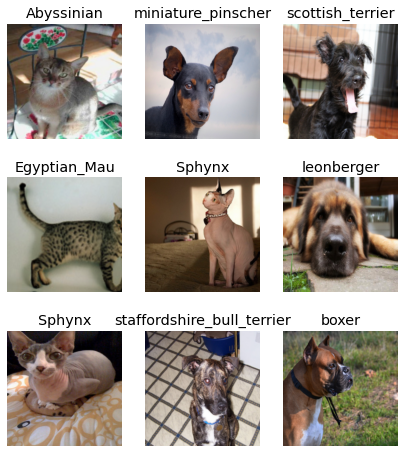

In [35]:
dls_single.show_batch(max_n=9, figsize=(7,8))

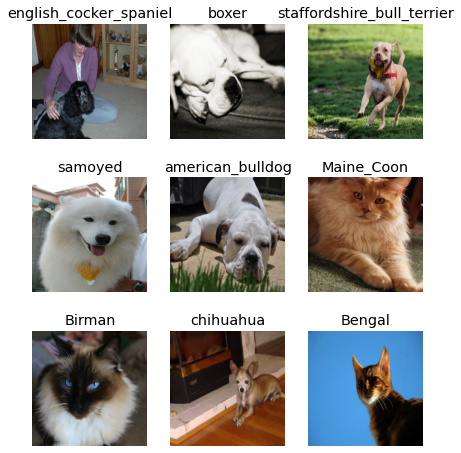

In [36]:
dls_multi.show_batch(max_n=9, figsize=(7,8))

### Train and evaluate the single-label classification model first

In [38]:
learn_single = cnn_learner(dls_single, resnet34, pretrained=True, metrics=accuracy)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.00363078061491251)

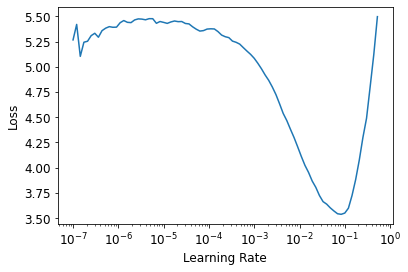

In [40]:
learn_single.lr_find()

In [41]:
learn_single.fine_tune(4, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.008489,0.358443,0.876184,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.514506,0.399833,0.880920,00:39
1,0.440027,0.321655,0.903248,00:40
2,0.251060,0.228398,0.923545,00:40
3,0.115164,0.199281,0.930311,00:40


In [42]:
learn_single.save("pets-single-best-resnet34")

Path('models/pets-single-best-resnet34.pth')

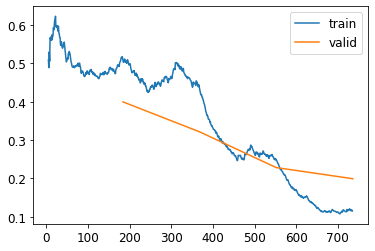

In [43]:
learn_single.recorder.plot_loss()

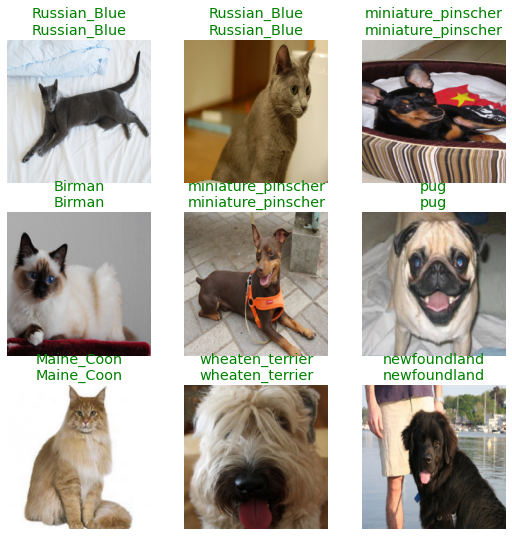

In [44]:
learn_single.show_results()

### Let's see how the model predicts on test images (from the Internet)

<AxesSubplot:>

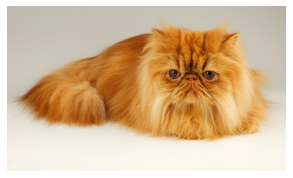

In [48]:
img = PILImage.create('persian_cat.jpg')
img.show()

In [49]:
learn_single.predict(img)

('Persian',
 tensor(7),
 tensor([8.6543e-08, 5.4637e-08, 4.0302e-06, 4.8134e-08, 1.6625e-06, 1.1779e-08, 8.0148e-06, 9.9998e-01, 8.9213e-07, 1.2397e-10, 3.1862e-10, 3.0510e-08, 1.4689e-09, 3.4483e-10, 5.5071e-08, 5.3021e-10,
         1.2125e-08, 9.0605e-10, 4.4580e-09, 8.4903e-10, 2.9560e-09, 4.4305e-09, 6.9695e-08, 4.4511e-06, 4.9368e-09, 1.3574e-08, 2.7102e-09, 6.5724e-07, 9.9739e-07, 1.0707e-07, 1.3508e-07, 1.1465e-08,
         2.4983e-09, 5.1974e-09, 2.3698e-10, 1.1149e-08, 2.4109e-07]))

Gets the right answer for a persian cat image from the Internet. Not bad. How about an image from a category its not seen before? Let's try a donkey image.

<AxesSubplot:>

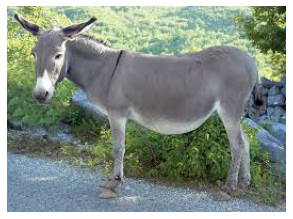

In [51]:
img = PILImage.create('donkey.jpg')
img.show()

In [52]:
learn_single.predict(img)

('american_pit_bull_terrier',
 tensor(13),
 tensor([6.8285e-03, 2.6866e-04, 2.4101e-04, 2.0642e-04, 3.9007e-04, 4.6434e-03, 2.0361e-04, 2.9735e-05, 2.3561e-04, 7.4638e-02, 2.1234e-03, 2.9009e-02, 5.6169e-03, 4.2922e-01, 1.6631e-03, 9.5369e-03,
         1.8752e-02, 4.2473e-03, 2.3025e-04, 1.1018e-02, 2.5009e-02, 4.0329e-03, 4.3327e-05, 2.0865e-04, 1.8217e-02, 2.1598e-04, 3.3468e-01, 1.9827e-04, 7.4498e-05, 2.1756e-03, 4.7525e-05, 3.9339e-03,
         1.0191e-03, 6.1575e-03, 4.6382e-03, 1.6563e-04, 7.9941e-05]))

Calls it an "american_pit_bull_terrier". Not right.

### Let's train the multi-label classifier now

Key thing to note here. The accuracy function used will use a high threshold of 0.95 so that only results the model is very confident about will be selected. For the loss function, we use the binary_cross_entropy loss function as specified in the textbook.

In [57]:
learn_multi = cnn_learner(dls_multi, resnet34, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.95)])

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.03981071710586548)

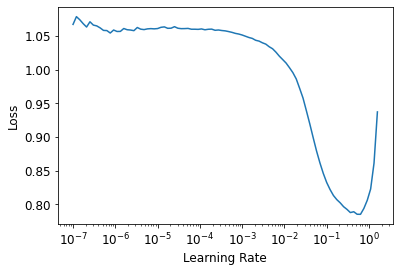

In [58]:
learn_multi.lr_find()

In [59]:
learn_multi.fine_tune(epochs=4, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.413710,0.065867,0.973741,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.053688,0.023568,0.981970,00:40
1,0.027428,0.014555,0.989431,00:40
2,0.015373,0.010602,0.991790,00:40
3,0.010254,0.009575,0.992576,00:40


In [60]:
learn_multi.save("pets-multi-best-resnet34")

Path('models/pets-multi-best-resnet34.pth')

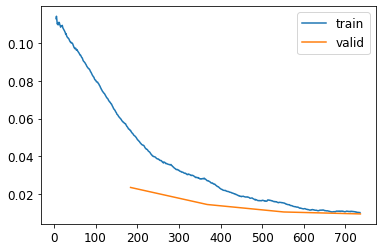

In [61]:
learn_multi.recorder.plot_loss()

Wow! That looks great and also the accuracy is better than that for the single-label classification model (?).

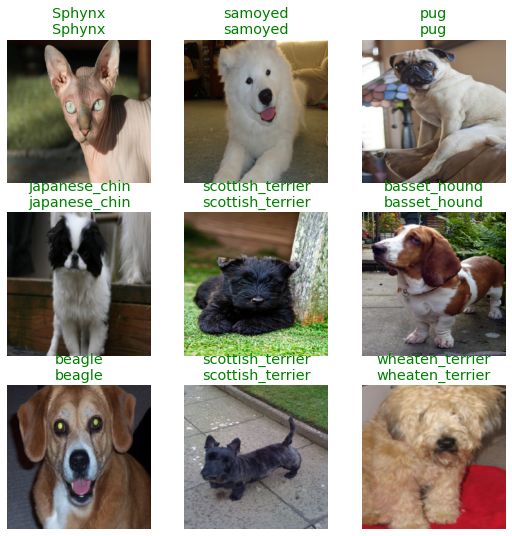

In [62]:
learn_multi.show_results()

<AxesSubplot:>

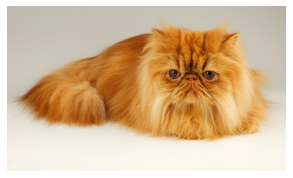

In [64]:
img = PILImage.create("persian_cat.jpg"); 
img.show()

In [65]:
learn_multi.predict(img)

((#1) ['Persian'],
 tensor([False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([1.3112e-04, 3.7481e-04, 9.7096e-04, 7.3606e-05, 2.6053e-04, 1.2581e-04, 1.1585e-03, 9.9327e-01, 1.4942e-04, 2.8816e-05, 1.7016e-04, 2.6868e-04, 3.1796e-04, 7.9010e-04, 1.3533e-04, 4.2544e-04,
         4.4185e-04, 3.6798e-05, 2.6048e-04, 5.3761e-05, 1.7554e-04, 3.8640e-04, 2.1269e-04, 1.7576e-03, 6.0463e-05, 3.0593e-04, 3.0365e-04, 4.0525e-04, 4.3490e-04, 3.1499e-04, 3.1902e-04, 7.0238e-04,
         1.4212e-04, 1.6981e-04, 1.0651e-04, 1.8955e-04, 3.7189e-04]))

Correct prediction!

<AxesSubplot:>

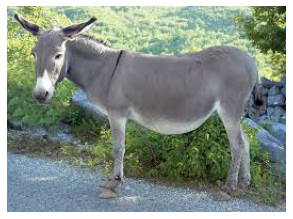

In [66]:
img = PILImage.create("donkey.jpg"); 
img.show()

In [67]:
learn_multi.predict(img)

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([0.0019, 0.0005, 0.0006, 0.0005, 0.0004, 0.0041, 0.0003, 0.0014, 0.0008, 0.0292, 0.0006, 0.0223, 0.0006, 0.0495, 0.0058, 0.0098, 0.0166, 0.0017, 0.0004, 0.0064, 0.0037, 0.0016, 0.0004, 0.0004,
         0.0018, 0.0012, 0.1673, 0.0016, 0.0004, 0.0005, 0.0006, 0.0016, 0.0049, 0.0053, 0.0014, 0.0003, 0.0003]))

Superb! No prediction crossed the high threshold set and if you look at the activations, all values are low! This is what we want. The only thing we did was to set the threshold for accuracy_multi to be 0.95 and used Pipeline to first use the RegexLabeller like before and pass in a list of the category instead of the label itself. Nothing magical but good to have A multi-label classifier work as we need it to.